In [2]:
%load_ext autoreload
%autoreload 1

print('please anything')

import SimpleITK as sitk
import os, sys

print('zapatos')

sys.path.append('./workflow/libs/')
%aimport utils
%aimport config
%aimport segment 
%aimport match 
%aimport missingness 
%aimport register 
%aimport evaluate 
%aimport qc 

print('yabadabodoo')

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sbn
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
please anything
zapatos
yabadabodoo


# Results Visualization 

Tool for interacting with results on exahead. 


## Overview

The file `aggregated_results.csv` is formed from three different sources: 
- each core-directory's parsed names: This contains the core name and the absolute path; This can be used to track and organize the data. **BUG** - currently R0 is not included in this dataset. 
- the original core segmentation stats: this will include the original file name and segmentation statistics. 
- registration results: This contains registration success metrics 

Because of this, there is substantial missingness between row observations depending on which source it came from. 

## Data Dictionary 

> **status**: whether the core has been registered or not. Note that `R0-c1` will never be titled as `registered` since this is the reference image.  

> **core**: core identifier, this is the core cluster label assigned during segmentation and across-round matching.   

> **round**: The image round identifier, should be in format `R<int>`. Note that R0 is autofluorescence only, except for R0,c1 which is DAPI used for registration reference frame. 

> **color_channel**: fluorescence wavelength measured. c1 is always DAPI, c2-5 may reflect different protein antibodies depending on the round. The specific channel-protein mapping is encoded in the original scan name. 

> **path**: *local path* or core file name. 

> **center_x/y**: core segmentation center x/y coordinate, in reference to the original (potentially downsampled) scan image (full scan-scene).  

> **width/height**: core segmentation width/height (potentitally downsampled); see config.py for details.  

> **volume (nm^3)**:  

> **Elongation**:  

> **Flatness**:  

> **Oriented Bounding Box Minimum/Maximum Size(nm)**:  

> **Intensity Mean**:  

> **Intensity Standard Deviation**:  

> **Intensity Skewness**:  

> **component**:  *why isn't this the same as `core` - aren't they assigned the same way??*   

> **img_name**: original scan-scene image name  

> **protein**: 

> **slide_name**:  

> **date**:  

> **scan_id**:  

> **scene**:  

> **note**:  

> **file_type**:  

> **original**: duplicate of `img_name`  

> **cluster**:  

> **name**: duplicate of `path` 

> **jacaard_coef**:  

> **dice_coef**:  

> **volume_similarity**:  

> **false_neg_err**:  

> **false_pos_err**:  

> **hausdorff_dist**:  

> **registered_path**: absolute path to this image, can be used for access and tracking.   

In [3]:
res = pd.read_csv('/home/exacloud/lustre1/NGSdev/evansna/cyclicIF/output/aggregated_results.csv')

# drop unnecessary columns 
res = res.drop(['Unnamed: 0', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)

# select only registered results -- keep R0 unregistered as this is the aligned reference 
res = res[(res.status == 'registered') | (res.round == 'R0')]

res.head()

status  core round color_channel  \
2   registered    56    R1            c1   
3   registered    56    R2            c3   
6   registered    56    R1            c4   
10  registered    56    R2            c5   
16  registered    56    R1            c5   

                                        path  center_x  center_y  width  \
2   registered_core=56_round=R1_color=c1.tif     866.0    1860.0  125.0   
3   registered_core=56_round=R2_color=c3.tif       NaN       NaN    NaN   
6   registered_core=56_round=R1_color=c4.tif       NaN       NaN    NaN   
10  registered_core=56_round=R2_color=c5.tif       NaN       NaN    NaN   
16  registered_core=56_round=R1_color=c5.tif       NaN       NaN    NaN   

    height  Volume (nm^3)  Elongation  Flatness  \
2    124.0       0.496815    1.040836  1.040836   
3      NaN            NaN         NaN       NaN   
6      NaN            NaN         NaN       NaN   
10     NaN            NaN         NaN       NaN   
16     NaN            NaN         NaN       NaN   

    Oriented Bounding Box Minimum Size(nm)  \
2                                 0.779983   
3                                      NaN   
6                                      NaN   
10                                     NaN   
16                                     NaN   

    Oriented Bounding Box Maximum Size(nm)  Intensity Mean  \
2                                 0.807438       16.881367   
3                                      NaN             NaN   
6                                      NaN             NaN   
10                                     NaN             NaN   
16                                     NaN             NaN   

    Intensity Standard Deviation  Intensity Skewness  component  \
2                      19.485183            1.611657       52.0   
3                            NaN                 NaN        NaN   
6                            NaN                 NaN        NaN   
10                           NaN                 NaN        NaN   
16                           NaN                 NaN        NaN   

                                             img_name  \
2   R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...   
3                                                 NaN   
6                                                 NaN   
10                                                NaN   
16                                                NaN   

                      protein slide_name        date  scan_id    scene note  \
2   H3K27me3.CCNB1.CCND1.Ki67         S3  2020-01-22  13485.0  Scene-1  ORG   
3                         NaN        NaN         NaN      NaN      NaN  NaN   
6                         NaN        NaN         NaN      NaN      NaN  NaN   
10                        NaN        NaN         NaN      NaN      NaN  NaN   
16                        NaN        NaN         NaN      NaN      NaN  NaN   

   file_type                                           original  cluster  \
2        tif  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...     56.0   
3        NaN                                                NaN      NaN   
6        NaN                                                NaN      NaN   
10       NaN                                                NaN      NaN   
16       NaN                                                NaN      NaN   

                                        name  jacaard_coef  dice_coef  \
2   registered_core=56_round=R1_color=c1.tif      0.730423   0.844213   
3                                        NaN           NaN        NaN   
6                                        NaN           NaN        NaN   
10                                       NaN           NaN        NaN   
16                                       NaN           NaN        NaN   

    volume_similarity  false_neg_err  false_pos_err  hausdorff_dist  \
2           -0.013636       0.161504       0.149991        0.011985   
3                 NaN            NaN            NaN             NaN   
6    

In [4]:
res[res.slide_name.isna()]

status  core round color_channel  \
3     registered    56    R2            c3   
6     registered    56    R1            c4   
10    registered    56    R2            c5   
16    registered    56    R1            c5   
18    registered    56    R2            c4   
...          ...   ...   ...           ...   
1946  registered    49    R2            c4   
1947  registered    49    R1            c2   
1954  registered    49    R2            c5   
1956  registered    49    R2            c3   
1959  registered    49    R1            c3   

                                          path  center_x  center_y  width  \
3     registered_core=56_round=R2_color=c3.tif       NaN       NaN    NaN   
6     registered_core=56_round=R1_color=c4.tif       NaN       NaN    NaN   
10    registered_core=56_round=R2_color=c5.tif       NaN       NaN    NaN   
16    registered_core=56_round=R1_color=c5.tif       NaN       NaN    NaN   
18    registered_core=56_round=R2_color=c4.tif       NaN       NaN    NaN   
...                                        ...       ...       ...    ...   
1946  registered_core=49_round=R2_color=c4.tif       NaN       NaN    NaN   
1947  registered_core=49_round=R1_color=c2.tif       NaN       NaN    NaN   
1954  registered_core=49_round=R2_color=c5.tif       NaN       NaN    NaN   
1956  registered_core=49_round=R2_color=c3.tif       NaN       NaN    NaN   
1959  registered_core=49_round=R1_color=c3.tif       NaN       NaN    NaN   

      height  Volume (nm^3)  Elongation  Flatness  \
3        NaN            NaN         NaN       NaN   
6        NaN            NaN         NaN       NaN   
10       NaN            NaN         NaN       NaN   
16       NaN            NaN         NaN       NaN   
18       NaN            NaN         NaN       NaN   
...      ...            ...         ...       ...   
1946     NaN            NaN         NaN       NaN   
1947     NaN            NaN         NaN       NaN   
1954     NaN            NaN         NaN       NaN   
1956     NaN            NaN         NaN       NaN   
1959     NaN            NaN         NaN       NaN   

      Oriented Bounding Box Minimum Size(nm)  \
3                                        NaN   
6                                        NaN   
10                                       NaN   
16                                       NaN   
18                                       NaN   
...                                      ...   
1946                                     NaN   
1947                                     NaN   
1954                                     NaN   
1956                                     NaN   
1959                                     NaN   

      Oriented Bounding Box Maximum Size(nm)  Intensity Mean  \
3                                        NaN             NaN   
6                                        NaN             NaN   
10                                       NaN             NaN   
16                                       NaN             NaN   
18                                       NaN             NaN   
...                                      ...             ...   
1946                                     NaN             NaN   
1947                                     NaN             NaN   
1954                                     NaN             NaN   
1956                                     NaN             NaN   
1959                                     NaN             NaN   

      Intensity Standard Deviation  Intensity Skewness  component img_name  \
3                              NaN                 NaN        NaN      NaN   
6                              NaN                 NaN        NaN      NaN   
10                             NaN                 NaN        NaN      NaN   
16                             NaN                 NaN        NaN      NaN   
18                             NaN                 NaN        NaN      NaN   
...                            ...                 ...        ...      ...   
194

## Available experiments 

why isn't `R0` available here? 


In [5]:
res[['slide_name', 'scene', 'round']].drop_duplicates()

slide_name    scene round
2          S3  Scene-1    R1
3         NaN      NaN    R2
6         NaN      NaN    R1
22         S3  Scene-1    R2

## choose experiment 

In [6]:
# results config params 

SCENE = 'Scene-1'
SLIDE = 'S3'

res = res[(res.slide_name == SLIDE) & (res.scene == SCENE)]

## Registration results 

In [7]:
# select only the DAPI results
regRes = res[res.color_channel == 'c1']
regRes.head()

status  core round color_channel  \
2   registered    56    R1            c1   
22  registered    56    R2            c1   
37  registered    76    R1            c1   
48  registered    76    R2            c1   
50  registered    79    R2            c1   

                                        path  center_x  center_y  width  \
2   registered_core=56_round=R1_color=c1.tif     866.0    1860.0  125.0   
22  registered_core=56_round=R2_color=c1.tif     843.0    1855.0  129.0   
37  registered_core=76_round=R1_color=c1.tif    1688.0     605.0  101.0   
48  registered_core=76_round=R2_color=c1.tif    1681.0     601.0  100.0   
50  registered_core=79_round=R2_color=c1.tif     939.0     585.0   78.0   

    height  Volume (nm^3)  Elongation  Flatness  \
2    124.0       0.496815    1.040836  1.040836   
22   129.0       0.529854    1.042322  1.042322   
37    88.0       0.292706    1.200337  1.200337   
48    92.0       0.303945    1.141331  1.141331   
50    96.0       0.243696    1.235295  1.235295   

    Oriented Bounding Box Minimum Size(nm)  \
2                                 0.779983   
22                                0.796409   
37                                0.555820   
48                                0.583335   
50                                0.505720   

    Oriented Bounding Box Maximum Size(nm)  Intensity Mean  \
2                                 0.807438       16.881367   
22                                0.834815        9.272865   
37                                0.657778       12.326934   
48                                0.655777        6.371282   
50                                0.626115        6.392857   

    Intensity Standard Deviation  Intensity Skewness  component  \
2                      19.485183            1.611657       52.0   
22                     12.545243            1.870409       44.0   
37                     22.551267            3.139400       76.0   
48                     12.773178            3.333198       76.0   
50                     11.742703            2.999989       80.0   

                                             img_name  \
2   R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...   
22  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene...   
37  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...   
48  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene...   
50  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene...   

                      protein slide_name        date  scan_id    scene note  \
2   H3K27me3.CCNB1.CCND1.Ki67         S3  2020-01-22  13485.0  Scene-1  ORG   
22           PCNA.AR.ER.GATA3         S3  2020-01-23  13492.0  Scene-1  ORG   
37  H3K27me3.CCNB1.CCND1.Ki67         S3  2020-01-22  13485.0  Scene-1  ORG   
48           PCNA.AR.ER.GATA3         S3  2020-01-23  13492.0  Scene-1  ORG   
50           PCNA.AR.ER.GATA3         S3  2020-01-23  13492.0  Scene-1  ORG   

   file_type                                           original  cluster  \
2        tif  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...     56.0   
22       tif  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene...     56.0   
37       tif  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...     76.0   
48       tif  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene...     76.0   
50       tif  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene...     79.0   

                                        name  jacaard_coef  dice_coef  \
2   registered_core=56_round=R1_color=c1.tif      0.730423   0.844213   
22  registered_core=56_round=R2_color=c1.tif      0.547198   0.707340   
37  registered_core=76_round=R1_color=c1.tif      0.720407   0.837484   
48  registered_core=76_round=R2_color=c1.tif      0.487016   0.655025   
50  registered_core=79_round=R2_color=c1.tif      0.505547   0.671579   

    volume_similarity  false_neg_err  false_pos_err  hausdorff_dist  \
2           -0.013636       0.161504       0.149991        0.011985   
22           0.114827       0.249575       0.331066        0.022526   
37   

# Registration Results 

Why is there such clear separation between rounds? 
- something to do with lost material? I guess we would expect later rounds to register more poorly... 

Note: R1 has better metrics than R2. 

In [8]:
vizRes = regRes[['round',*'jacaard_coef,dice_coef,volume_similarity,false_neg_err,false_pos_err,hausdorff_dist'.split(',')]]

In [34]:
vizRes.summary()

AttributeError: 'DataFrame' object has no attribute 'summary'

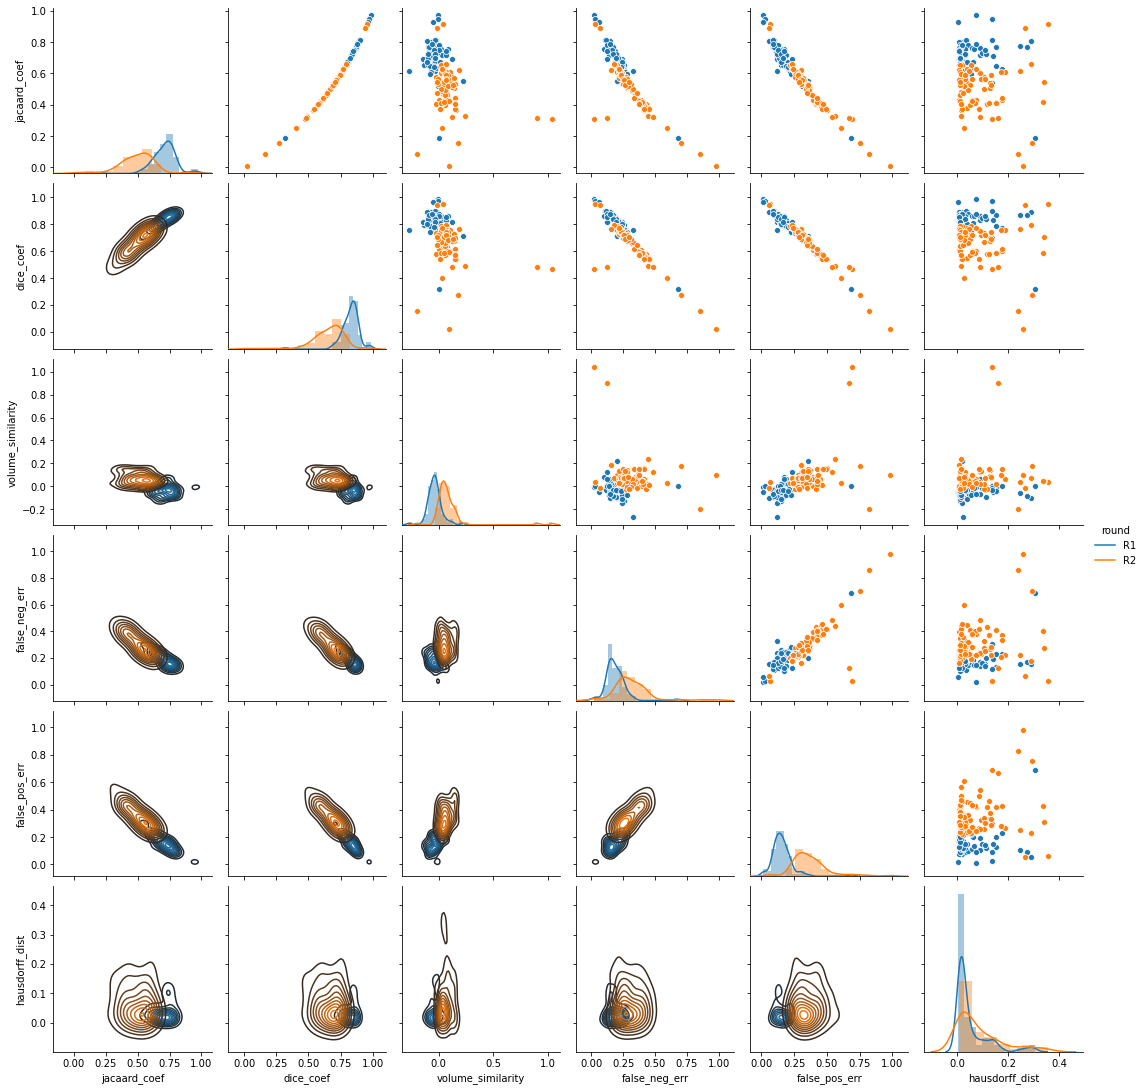

In [9]:
g = sbn.PairGrid(vizRes, hue='round')
g.map_upper(sbn.scatterplot)
g.map_diag(sbn.distplot)
g.map_lower(sbn.kdeplot)
g.add_legend()

## Outlier detection


Outlier detection does work, however, it also selects the *Really GOOD* registrations as outliers. It might be better to hardcode thresholds for **poor** registration... 

https://scikit-learn.org/stable/modules/outlier_detection.html

https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py

In [10]:
regRes['jacaard_coef,dice_coef,volume_similarity,false_neg_err,false_pos_err,hausdorff_dist'.split(',')].corr(method='spearman')

jacaard_coef  dice_coef  volume_similarity  false_neg_err  \
jacaard_coef           1.000000   1.000000          -0.594732      -0.887288   
dice_coef              1.000000   1.000000          -0.594732      -0.887288   
volume_similarity     -0.594732  -0.594732           1.000000       0.289793   
false_neg_err         -0.887288  -0.887288           0.289793       1.000000   
false_pos_err         -0.976628  -0.976628           0.718660       0.807835   
hausdorff_dist        -0.147085  -0.147085           0.143227       0.086324   

                   false_pos_err  hausdorff_dist  
jacaard_coef           -0.976628       -0.147085  
dice_coef              -0.976628       -0.147085  
volume_similarity       0.718660        0.143227  
false_neg_err           0.807835        0.086324  
false_pos_err           1.000000        0.138103  
hausdorff_dist          0.138103        1.000000

In [11]:
## Exclude jacaard and dice since they are highly correlated [by rank] with the other features
## what proportion of outliers do we expect?????

X = regRes['volume_similarity,false_neg_err,false_pos_err,hausdorff_dist'.split(',')].values

clf = IsolationForest(max_samples='auto', bootstrap=True, contamination=0.15, max_features=3)
clf.fit(X)

outliers = clf.predict(X)

_, cnts = np.unique(outliers, return_counts=True)

print(f'number of outliers: {cnts[0]}/{cnts[1]} [{100*cnts[0]/np.sum(cnts):.1f}%]')

number of outliers: 24/133 [15.3%]


In [12]:
pca = PCA(n_components=2, svd_solver='full')
pca.fit(X)
PC = pca.transform(X)

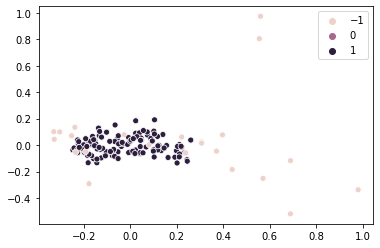

In [13]:
plt.figure()
sbn.scatterplot(PC[:,0], PC[:,1], hue=outliers)
plt.show()

In [14]:
outliersBool = outliers == -1
outRes = regRes[outliersBool]

print('number of outliers:', outRes.shape[0])

number of outliers: 24


## Manual thresholding 

We'll try just using the 10th/90th percentiles

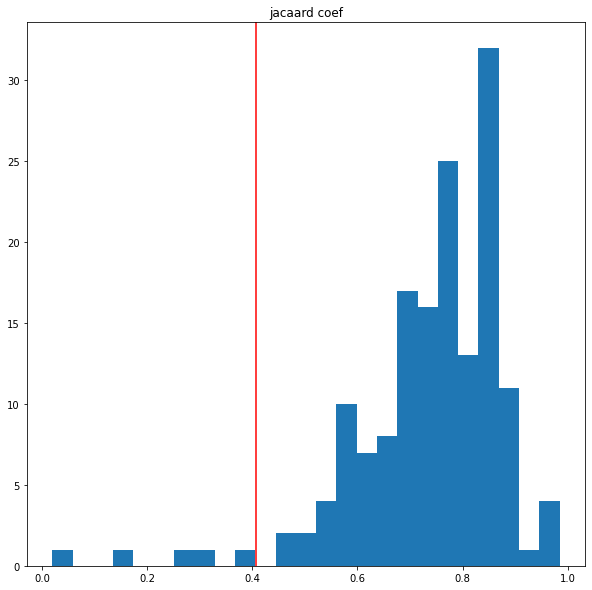

In [28]:
# higher is better 
vs_thresh = np.quantile(vizRes.jacaard_coef, 0.1)
plt.figure(figsize=(10,10))
plt.hist(vizRes.dice_coef, bins=25)
plt.axvline(vs_thresh, c='r')
plt.title('jacaard coef')
plt.show()

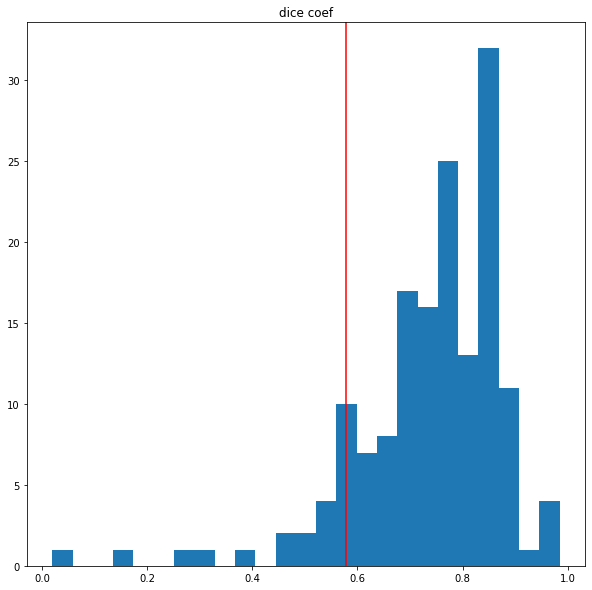

In [30]:
# higher is better 
vs_thresh = np.quantile(vizRes.dice_coef, 0.1)
plt.figure(figsize=(10,10))
plt.hist(vizRes.dice_coef, bins=25)
plt.axvline(vs_thresh, c='r')
plt.title('dice coef')
plt.show()

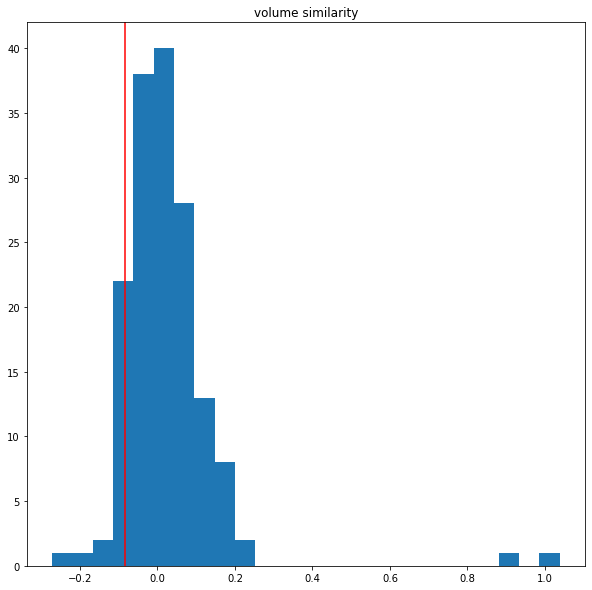

In [15]:
# higher is better 
vs_thresh = np.quantile(vizRes.volume_similarity, 0.1)
plt.figure(figsize=(10,10))
plt.hist(vizRes.volume_similarity, bins=25)
plt.axvline(vs_thresh, c='r')
plt.title('volume similarity')
plt.show()

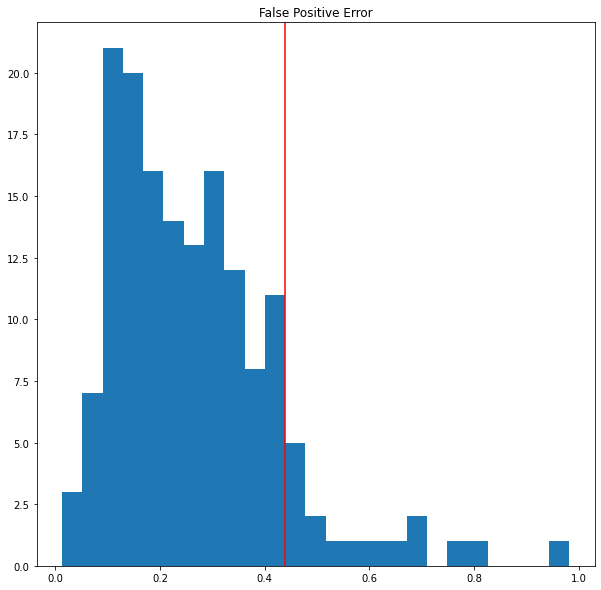

In [16]:
# lower is better 
FP_thresh = np.quantile(vizRes.false_pos_err, 0.9)
plt.figure(figsize=(10,10))
plt.hist(vizRes.false_pos_err, bins=25)
plt.axvline(FP_thresh, c='r')
plt.title('False Positive Error')
plt.show()

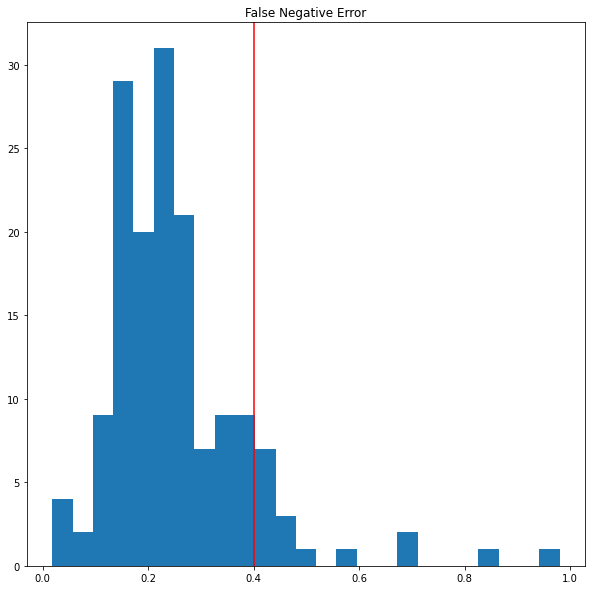

In [17]:
# lower is better 
FN_thresh = np.quantile(vizRes.false_neg_err, 0.9)
plt.figure(figsize=(10,10))
plt.hist(vizRes.false_neg_err, bins=25)
plt.axvline(FN_thresh, c='r')
plt.title('False Negative Error')
plt.show()

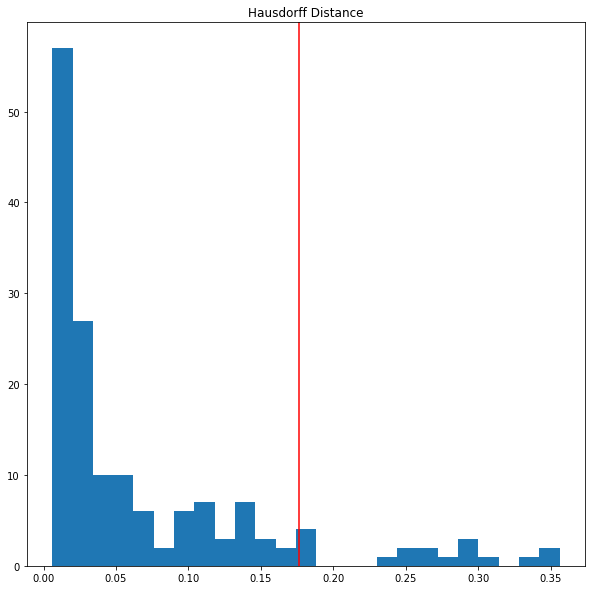

In [18]:
# lower is better 
hd_thresh = np.quantile(vizRes.hausdorff_dist, 0.9)
plt.figure(figsize=(10,10))
plt.hist(vizRes.hausdorff_dist, bins=25)
plt.axvline(hd_thresh, c='r')
plt.title('Hausdorff Distance')
plt.show()

In [32]:
FPR_threshold = 0.5
FNR_threshold = 0.5
hausdorff_distance_threshold = 0.2

outRes = regRes[lambda x: (x.false_pos_err > config.FPR_threshold) | (x.false_neg_err > config.FNR_threshold) | (x.hausdorff_dist > config.hausdorff_distance_threshold)]

print('number of outliers:', outRes.shape[0])

number of outliers: 19


## inspect possible outliers

##################################################
registered_core=73_round=R2_color=c1.tif
##################################################
volume similarity: 0.24096086771357256
FPR: 0.5620934529078943
FNR: 0.4421207477781183
hausdorff dist: 0.017160402028433278


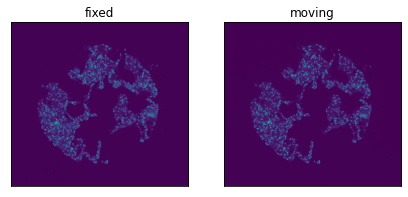

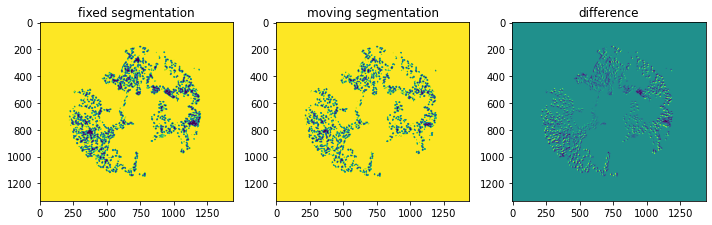

##################################################
registered_core=51_round=R2_color=c1.tif
##################################################
volume similarity: 0.03974653296885458
FPR: 0.06445998255370189
FNR: 0.026521549822929653
hausdorff dist: 0.35622718268322484


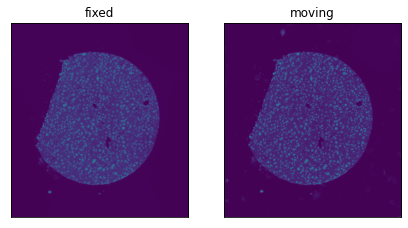

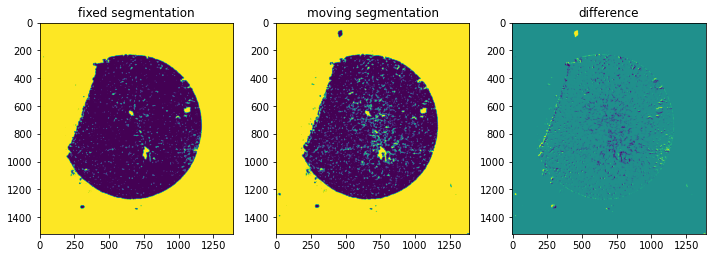

##################################################
registered_core=1_round=R2_color=c1.tif
##################################################
volume similarity: 0.12189343883923195
FPR: 0.542991220537681
FNR: 0.48366937708067
hausdorff dist: 0.09112015437024372


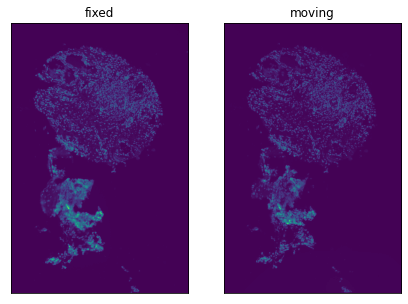

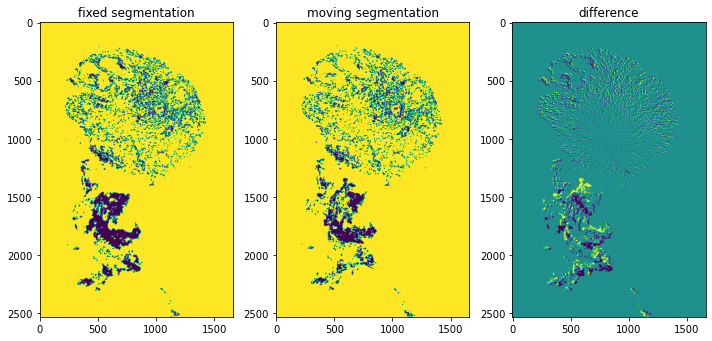

##################################################
registered_core=69_round=R2_color=c1.tif
##################################################
volume similarity: 1.0377375660163055
FPR: 0.6905420728311207
FNR: 0.02308150327484151
hausdorff dist: 0.13939206509401006


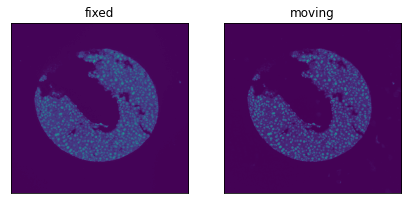

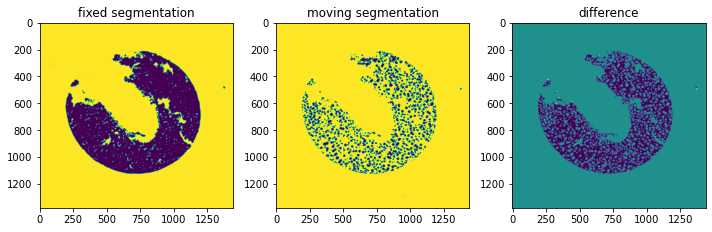

##################################################
registered_core=20_round=R2_color=c1.tif
##################################################
volume similarity: 0.045260369369320964
FPR: 0.3078909688013136
FNR: 0.275840551543657
hausdorff dist: 0.3423551157364515


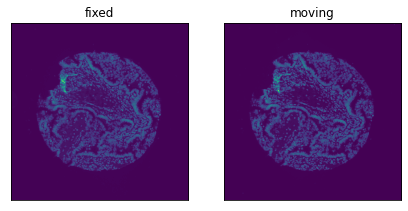

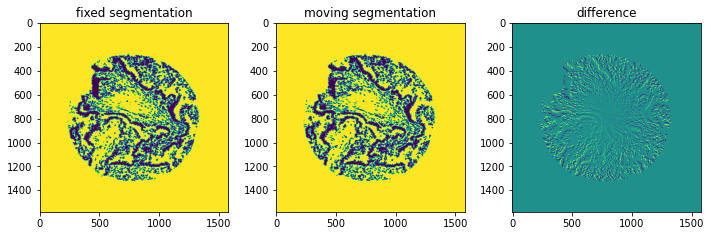

##################################################
registered_core=65_round=R2_color=c1.tif
##################################################
volume similarity: 0.15973561002478656
FPR: 0.5013150344299924
FNR: 0.4147429661777911
hausdorff dist: 0.015734751088550342


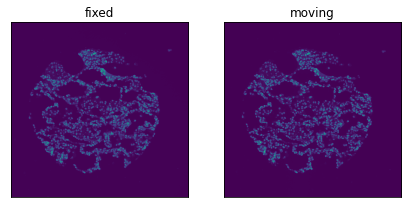

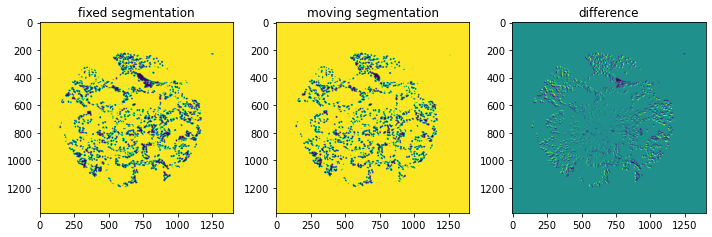

##################################################
registered_core=48_round=R2_color=c1.tif
##################################################
volume similarity: -0.011306814872746334
FPR: 0.05490872021431329
FNR: 0.06553461981288823
hausdorff dist: 0.2664993889532674


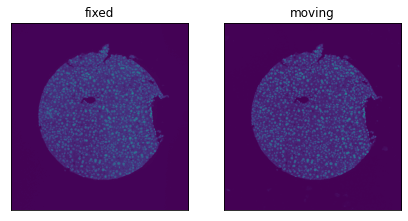

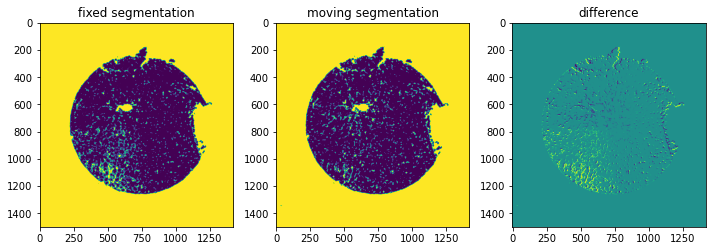

##################################################
registered_core=42_round=R2_color=c1.tif
##################################################
volume similarity: -0.2014882018933062
FPR: 0.8248392350608654
FNR: 0.8569019347741685
hausdorff dist: 0.2398566633046585


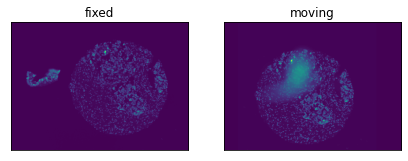

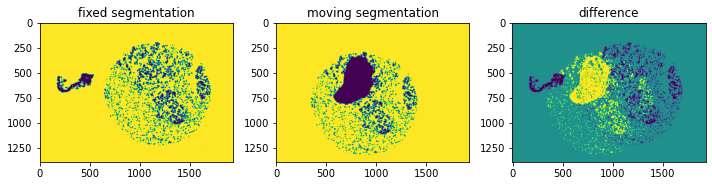

##################################################
registered_core=19_round=R1_color=c1.tif
##################################################
volume similarity: -0.10463256926246467
FPR: 0.05672367142560506
FNR: 0.1505143189948297
hausdorff dist: 0.2900186828913211


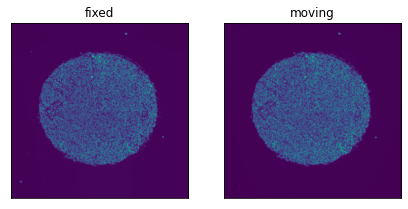

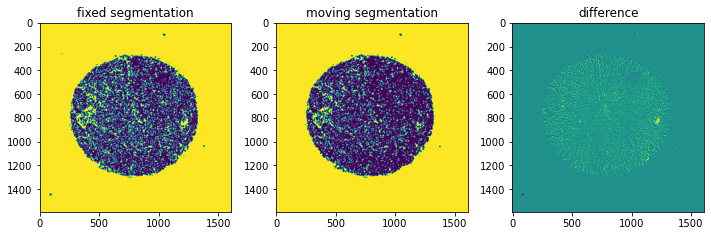

##################################################
registered_core=19_round=R2_color=c1.tif
##################################################
volume similarity: 0.0707381778227451
FPR: 0.23270875899334745
FNR: 0.17644186600428732
hausdorff dist: 0.2900274234837231


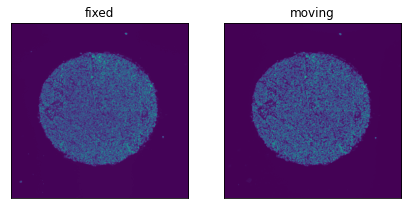

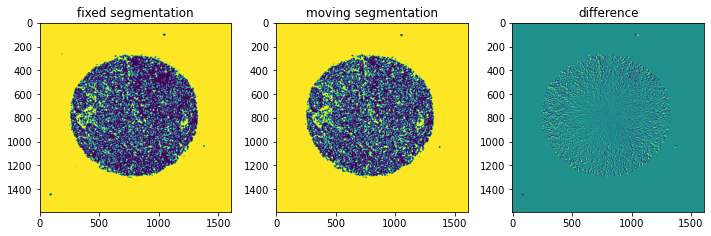

##################################################
registered_core=28_round=R2_color=c1.tif
##################################################
volume similarity: 0.17829710587930428
FPR: 0.7518296851333056
FNR: 0.7032509085954937
hausdorff dist: 0.2950533433040364


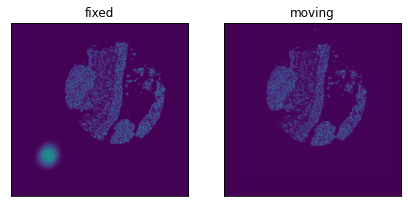

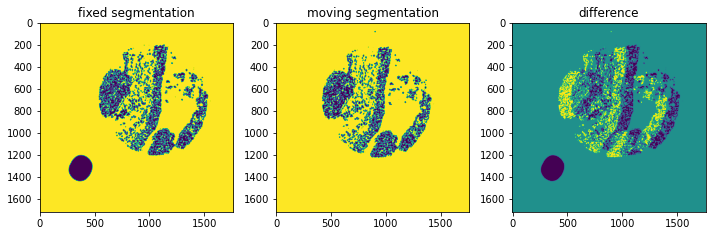

##################################################
registered_core=28_round=R1_color=c1.tif
##################################################
volume similarity: 0.007021602862446531
FPR: 0.6868054903958286
FNR: 0.6845986150294947
hausdorff dist: 0.3050174296771653


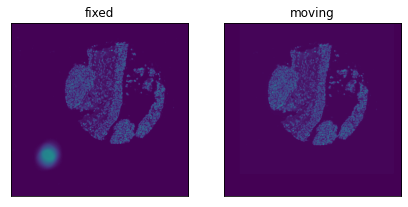

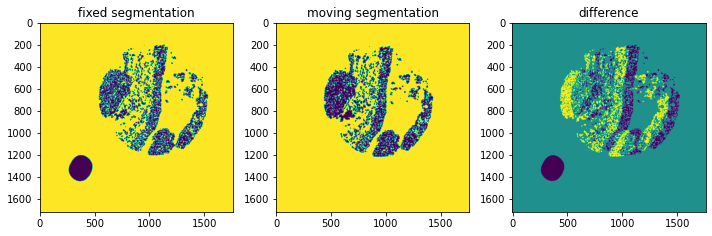

##################################################
registered_core=41_round=R2_color=c1.tif
##################################################
volume similarity: 0.9027005842455924
FPR: 0.6695970048279467
FNR: 0.12598060898169192
hausdorff dist: 0.16251084358775128


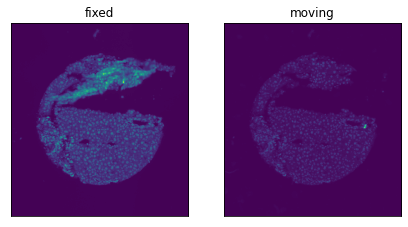

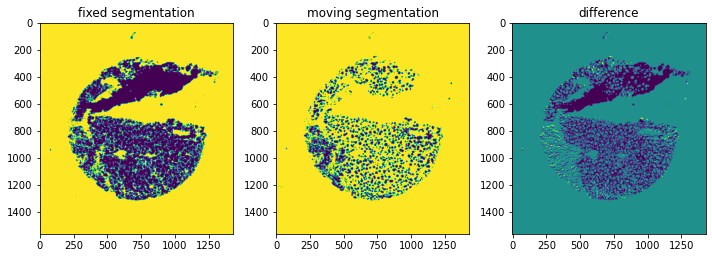

##################################################
registered_core=35_round=R2_color=c1.tif
##################################################
volume similarity: 0.049665403268533234
FPR: 0.4277460876979216
FNR: 0.3986011180356809
hausdorff dist: 0.335982846745594


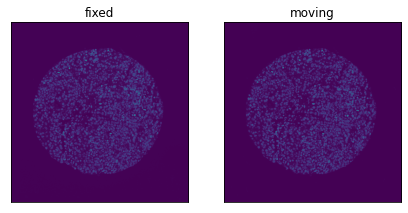

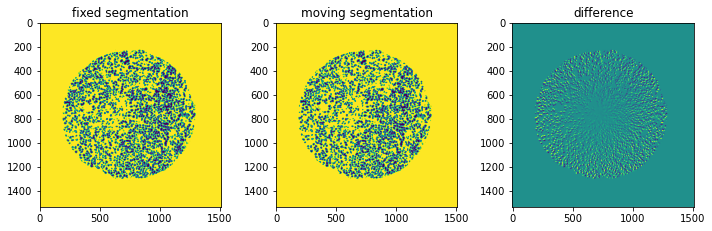

##################################################
registered_core=8_round=R1_color=c1.tif
##################################################
volume similarity: -0.0547753305834825
FPR: 0.10424092529279116
FNR: 0.1519984574277608
hausdorff dist: 0.2459711063070596


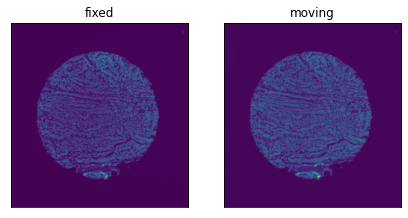

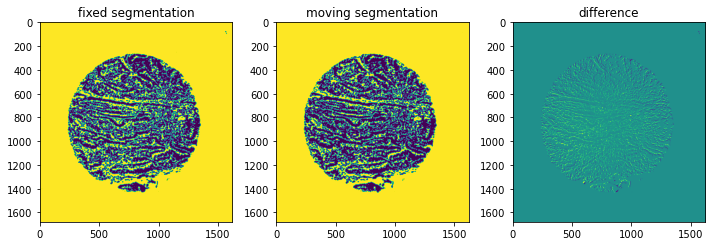

##################################################
registered_core=8_round=R2_color=c1.tif
##################################################
volume similarity: 0.041818976969857
FPR: 0.2541047339621574
FNR: 0.2222460073321816
hausdorff dist: 0.2459599412420232


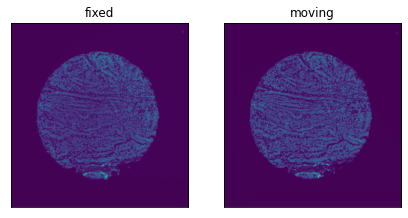

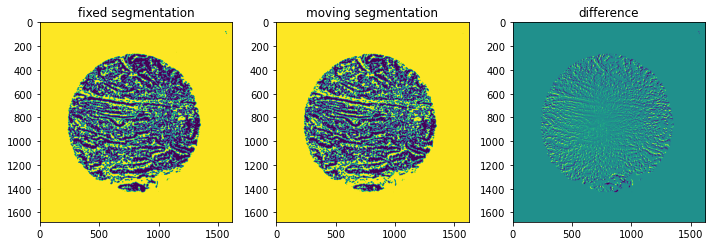

##################################################
registered_core=70_round=R2_color=c1.tif
##################################################
volume similarity: 0.09609178325285793
FPR: 0.981902091733871
FNR: 0.9800752596805798
hausdorff dist: 0.2596091533450099


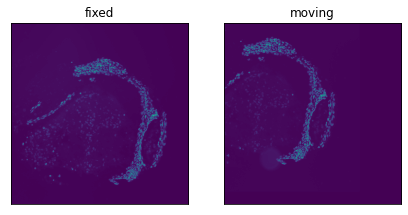

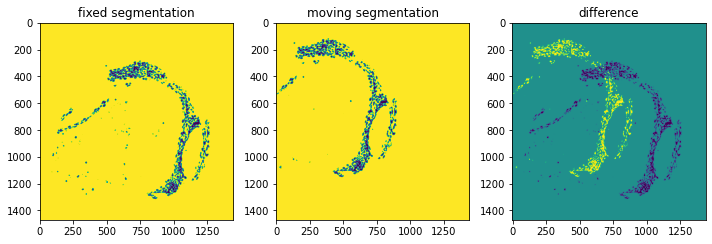

##################################################
registered_core=12_round=R1_color=c1.tif
##################################################
volume similarity: -0.08680511941806553
FPR: 0.09390489435183244
FNR: 0.1692868196864296
hausdorff dist: 0.2756476003238048


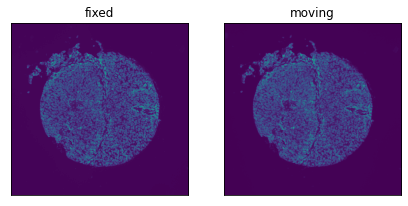

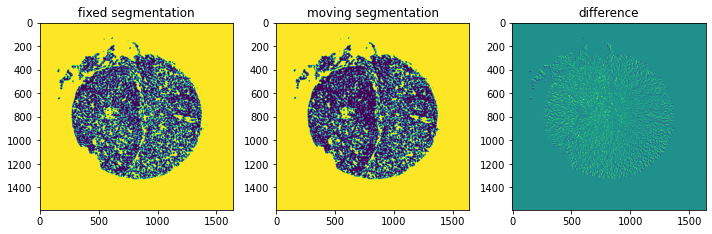

##################################################
registered_core=71_round=R2_color=c1.tif
##################################################
volume similarity: 0.02822994970526202
FPR: 0.6057487201365188
FNR: 0.5944596818431157
hausdorff dist: 0.026322855100707424


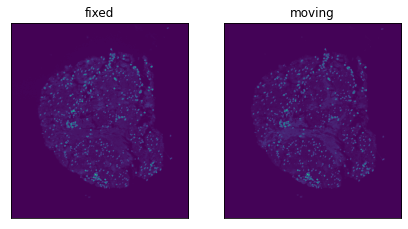

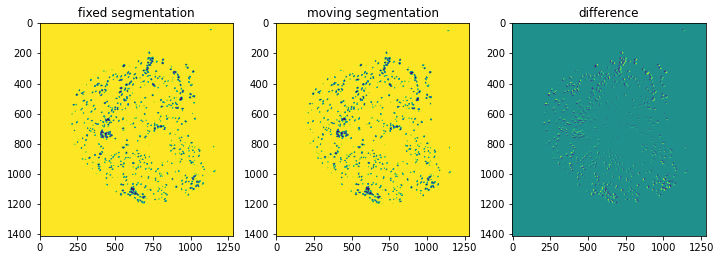

In [33]:
# for each core 
for i, row in outRes.iterrows(): 
    print('#'*50)
    print(row['name'])
    print('#'*50)
    print('volume similarity:', row.volume_similarity)
    print('FPR:', row.false_pos_err)
    print('FNR:', row.false_neg_err)
    print('hausdorff dist:', row.hausdorff_dist)
    img = sitk.ReadImage(row.registered_path)
    #utils.myshow(img)
    
    R0_dapi_path = f'{"/".join(row.registered_path.split("/")[:-1])}/unregistered_core={int(row.cluster)}_round=R0_color=c1.tif'
    
    R0_img = sitk.ReadImage(R0_dapi_path)
    #utils.myshow(img)
    
    f, axes = plt.subplots(1,2, figsize=(7,14))
    utils.myshow(R0_img, title='fixed', ax=axes[0])
    utils.myshow(img, title='moving', ax=axes[1])
    
    evaluate.plot_registration(R0_img, img)


# Registration Visualization

Build in some interactive widgets to visualize mapping. eg scroll select for which core(1) and round(R0 + 2) to include. 

Just a convenient way to pan through and visualize images. 

In [4]:
core_dir = '/home/exacloud/lustre1/NGSdev/evansna/cyclicIF/output/S3/Scene-1/core-001'
os.listdir(core_dir)

['unregistered_core=1_round=R2_color=c1.tif',
 'unregistered_core=1_round=R2_color=c2.tif',
 'unregistered_core=1_round=R0_color=c3.tif',
 'registered_core=1_round=R2_color=c3.tif',
 'registered_core=1_round=R1_color=c1.tif',
 'unregistered_core=1_round=R2_color=c3.tif',
 'unregistered_core=1_round=R2_color=c4.tif',
 'unregistered_core=1_round=R0_color=c5.tif',
 'registered_core=1_round=R2_color=c4.tif',
 'registered_core=1_round=R1_color=c3.tif',
 'unregistered_core=1_round=R2_color=c5.tif',
 'registered_core=1_round=R2_color=c2.tif',
 'registered_core=1_round=R1_color=c2.tif',
 'registered_core=1_round=R2_color=c5.tif',
 'unregistered_core=1_round=R0_color=c2.tif',
 'unregistered_core=1_round=R1_color=c5.tif',
 'unregistered_core=1_round=R1_color=c3.tif',
 'unregistered_core=1_round=R1_color=c4.tif',
 'unregistered_core=1_round=R1_color=c1.tif',
 'registered_core=1_round=R1_color=c5.tif',
 'registered_core=1_round=R1_color=c4.tif',
 'registered_core=1_round=R2_color=c1.tif',
 'unregi

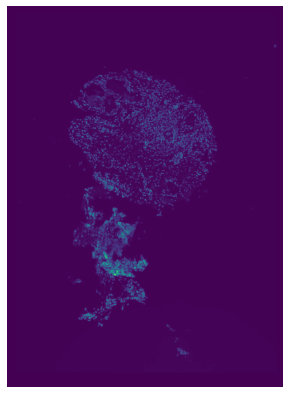

In [14]:
core0 = sitk.ReadImage(core_dir + '/unregistered_core=1_round=R0_color=c1.tif')
utils.myshow(core)

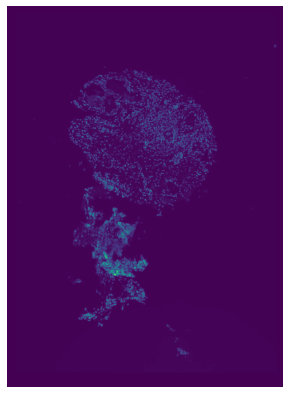

In [15]:
core1 = sitk.ReadImage(core_dir + '/registered_core=1_round=R1_color=c1.tif')
utils.myshow(core)

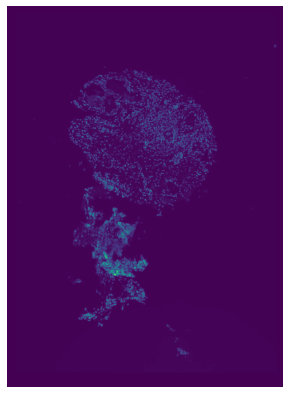

In [16]:
core2 = sitk.ReadImage(core_dir + '/registered_core=1_round=R2_color=c1.tif')
utils.myshow(core)

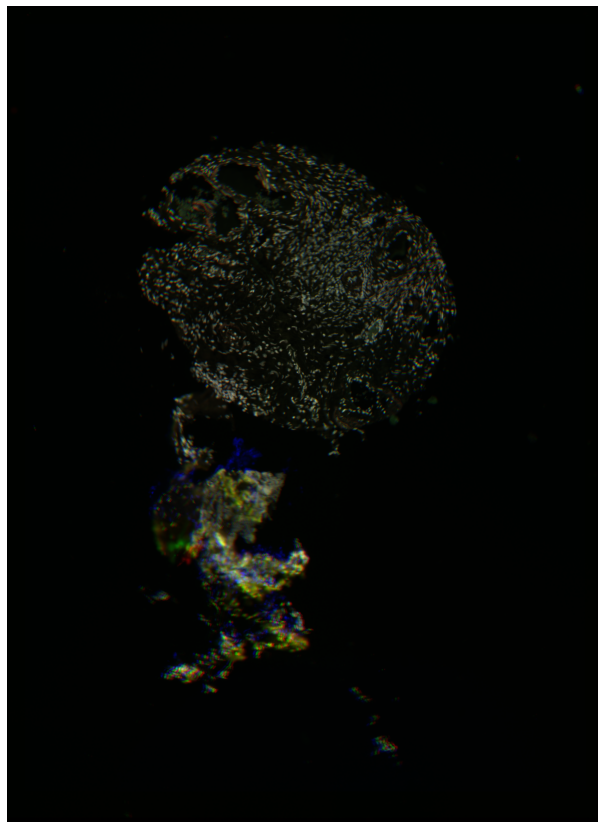

In [19]:
sigm1 = sitk.Cast(sitk.RescaleIntensity(core0), sitk.sitkUInt8)
sigm2 = sitk.Cast(sitk.RescaleIntensity(core1), sitk.sitkUInt8)
sigm3 = sitk.Cast(sitk.RescaleIntensity(core2), sitk.sitkUInt8)

cimg = sitk.Compose(sigm1, sigm2, sigm3)

utils.myshow(cimg, figsize=(15,15))

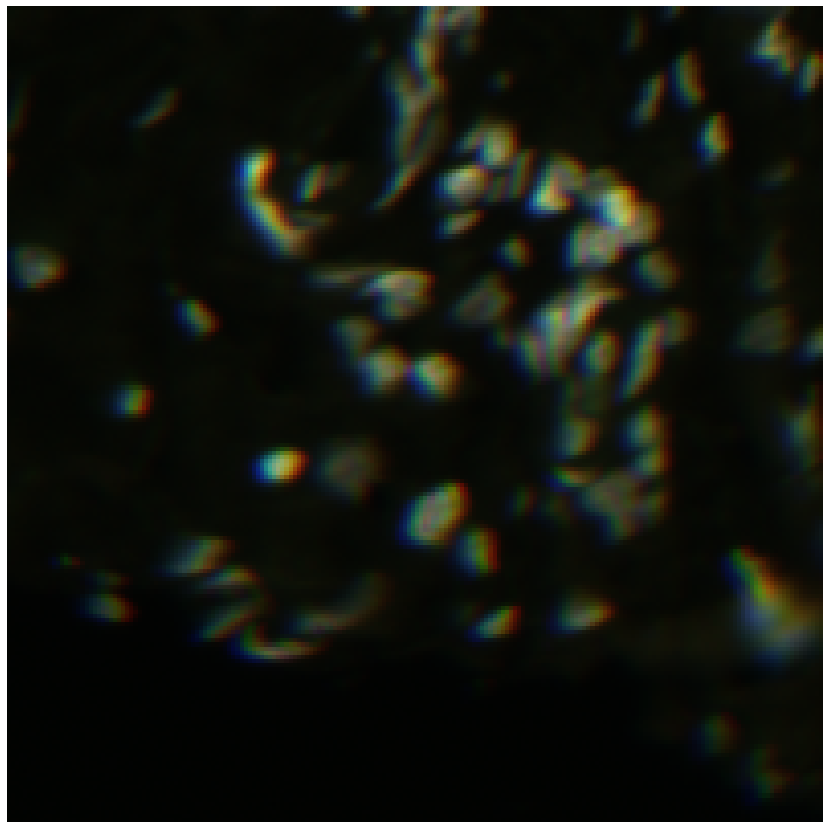

In [22]:
wsize = 100
x,y = cimg.GetSize()
utils.myshow(cimg[int(x/2-wsize):int(x/2+wsize), int(y/2-wsize):int(y/2+wsize)], figsize=(15,15))